# Empirical Application 4 Financial Econometrics

*By Daniel Deutsch, José Lucas Barretto, and Stéphane Roblet*

In [179]:
import warnings
import numpy as np
import pandas as pd
from IPython.display import display, clear_output
from matplotlib import pyplot as plt
from itertools import product
from statsmodels.tsa.seasonal import seasonal_decompose
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_arch

In [3]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

## Importing Datasets

The first thing we need to do here is get ourselves the data. We did it by downloading them as .csv in the following links:

- https://fred.stlouisfed.org/series/DAAA
- https://data.nasdaq.com/data/MULTPL/SP500_DIV_YIELD_MONTH-sp-500-dividend-yield-by-month
- https://fred.stlouisfed.org/series/IRLTLT01USM156N


In [17]:
# Import data
df_aaa = pd.read_csv("datasets/aaa.csv", names=['date', 'value'], parse_dates=['date'], skiprows=[0], na_values='.')
df_govbonds = pd.read_csv("datasets/govbonds.csv", names=['date', 'value'], parse_dates=['date'], skiprows=[0], na_values='.')
df_sp500 = pd.read_csv("./datasets/sp500.csv", names=['date', 'value'], parse_dates=['date'], skiprows=[0], na_values='.')

# Drop duplicates
df_aaa.drop_duplicates('date', inplace=True, ignore_index=True)
df_govbonds.drop_duplicates('date', inplace=True, ignore_index=True)
df_sp500.drop_duplicates('date', inplace=True, ignore_index=True)

# Remove not available data
df_aaa.dropna(inplace=True)
df_govbonds.dropna(inplace=True)
df_sp500.dropna(inplace=True)

## Removing Stochastic and Deterministic Trends

As we saw in empirical application I, the time series are I(1), and have statistically insignificant drift and trend coefficients. Let's calculate and plot the first difference of the series.

In [18]:
# Obtains the first difference
df_aaa['diff'] = df_aaa['value'].diff()
df_govbonds['diff'] = df_govbonds['value'].diff()
df_sp500['diff'] = df_sp500['value'].diff()

# Remove not available data
df_aaa.dropna(inplace=True)
df_govbonds.dropna(inplace=True)
df_sp500.dropna(inplace=True)

Finally, we can detect and remove seasonality from the time series. We will consider a yearly seasonality (253 trading days each year).

In [36]:
# Obtain seasonal components
df_aaa['diff_seasonal'] = seasonal_decompose(df_aaa['diff'], model='additive', period=253).seasonal
df_govbonds['diff_seasonal'] = seasonal_decompose(df_govbonds['diff'], model='additive', period=253).seasonal
df_sp500['diff_seasonal'] = seasonal_decompose(df_sp500['diff'], model='additive', period=253).seasonal

# Remove seasonal components
df_aaa['diff_adj'] = df_aaa['diff'] - df_aaa['diff_seasonal']
df_govbonds['diff_adj'] = df_govbonds['diff'] - df_govbonds['diff_seasonal']
df_sp500['diff_adj'] = df_sp500['diff'] - df_sp500['diff_seasonal']

Let's visualize the obtained results.

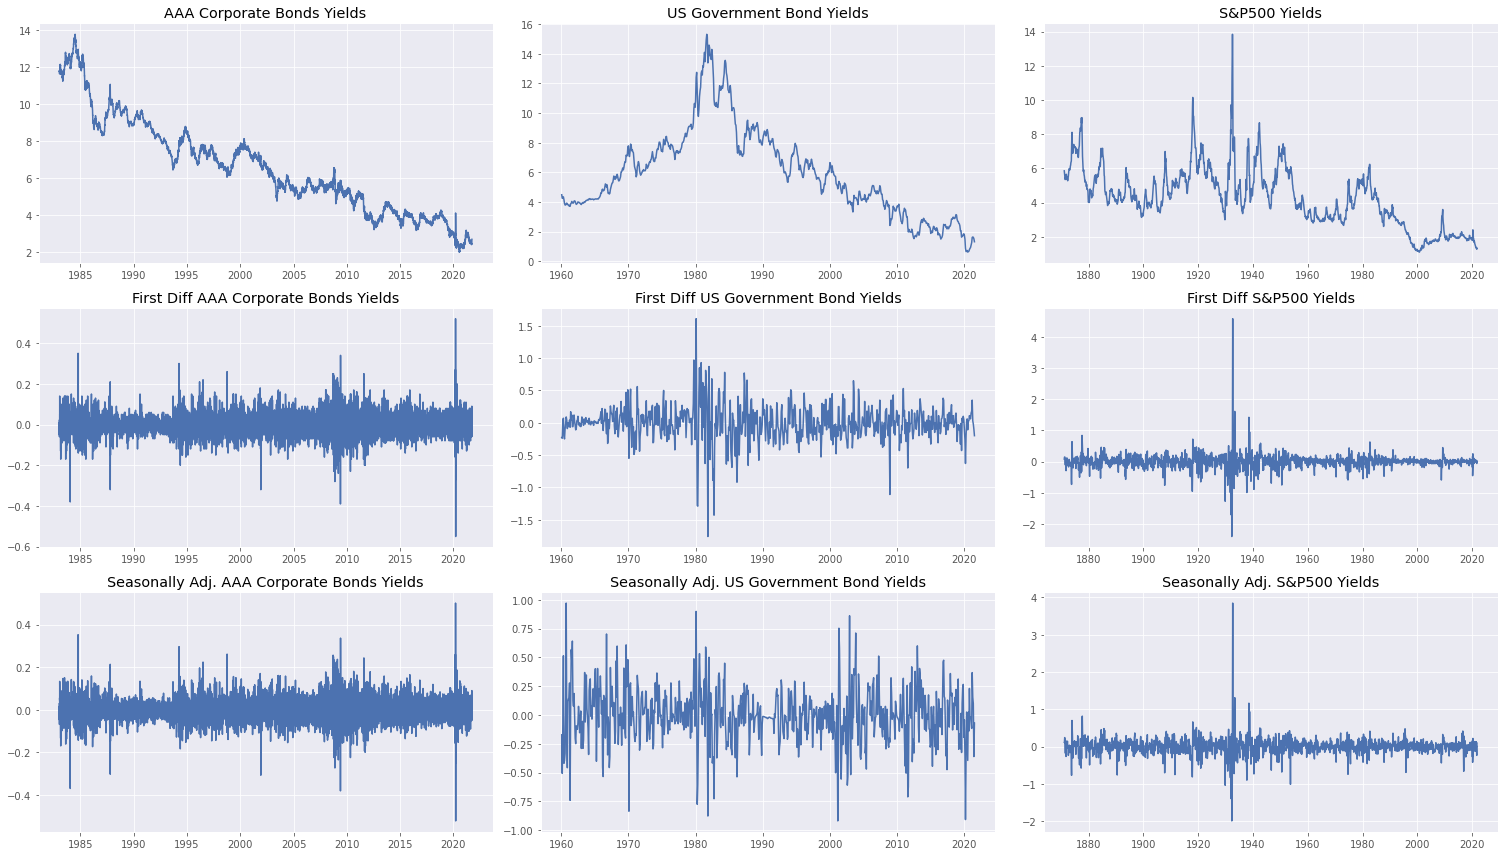

In [113]:
# Plot the original series, its first difference, and the seasonally adjusted series
fig, axs = plt.subplots(3, 3, figsize=(21, 12))
axs[0, 0].plot(df_aaa['date'], df_aaa['value'])
axs[0, 0].set_title("AAA Corporate Bonds Yields")
axs[1, 0].plot(df_aaa['date'], df_aaa['diff'])
axs[1, 0].set_title("First Diff AAA Corporate Bonds Yields")
axs[2, 0].plot(df_aaa['date'], df_aaa['diff_adj'])
axs[2, 0].set_title("Seasonally Adj. AAA Corporate Bonds Yields")
axs[0, 1].plot(df_govbonds['date'], df_govbonds['value'])
axs[0, 1].set_title("US Government Bond Yields")
axs[1, 1].plot(df_govbonds['date'], df_govbonds['diff'])
axs[1, 1].set_title("First Diff US Government Bond Yields")
axs[2, 1].plot(df_govbonds['date'], df_govbonds['diff_adj'])
axs[2, 1].set_title("Seasonally Adj. US Government Bond Yields")
axs[0, 2].plot(df_sp500['date'], df_sp500['value'])
axs[0, 2].set_title("S&P500 Yields")
axs[1, 2].plot(df_sp500['date'], df_sp500['diff'])
axs[1, 2].set_title("First Diff S&P500 Yields")
axs[2, 2].plot(df_sp500['date'], df_sp500['diff_adj'])
axs[2, 2].set_title("Seasonally Adj. S&P500 Yields")

plt.tight_layout()
plt.show()

## GARCH Model Estimations

Now, let's apply GARCH models for the variance of the three series, by selecting parameters q (number of lag variances to include) and p (number of lag residual errors to include) that minimize AIC. The mean series will be modeled as an AR process.

In [116]:
# parameter grid
q_candidates = [0, 1, 2, 3, 4]
p_candidates = [1, 2, 3, 4]

# initialize best fits dict
dfs_dict = {
    'aaa': df_aaa,
    'govbonds': df_govbonds,
    'sp500': df_sp500
}

best_params_dict = {
    'aaa': {'p': None, 'q': None},
    'govbonds': {'p': None, 'q': None},
    'sp500': {'p': None, 'q': None}
    }

for name in dfs_dict.keys():
    print(f"Testing models for {name}:")
    
    for i, (p,q) in enumerate(product(p_candidates, q_candidates)):

        model = arch_model(dfs[name]['diff_adj'], mean='AR', vol='GARCH', p=p, q=q)
        model_fit = model.fit(disp='off')
        
        if i == 0 or model_fit.aic < best_fit.aic:
            best_fit = model_fit
            best_params = {'p': p, 'q': q}

        print(f"\rProgress: {np.round(100*(i+1)/len(list(product(p_candidates, q_candidates))), 2)}%", end='')

    print('\nBest Params:', best_params, '\n')
    best_params_dict[name] = best_params

Testing models for aaa:
Progress: 100.0%
Best Params: {'p': 2, 'q': 3} 

Testing models for govbonds:
Progress: 100.0%
Best Params: {'p': 1, 'q': 1} 

Testing models for sp500:
Progress: 100.0%
Best Params: {'p': 1, 'q': 3} 



We can then visualize the conditional volatility estimated by the model.

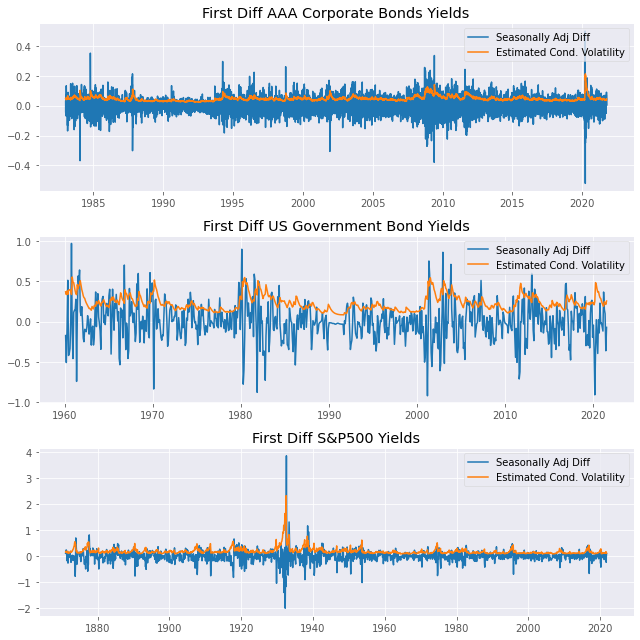

In [117]:
fig, ax = plt.subplots(3,1,figsize=(9,9))

# AAA Corporate Bond
(p,q) = (best_params_dict['aaa']['p'], best_params_dict['aaa']['q'])
model = arch_model(df_aaa['diff_adj'], mean='AR', vol='GARCH', p=p, q=q)
res = model.fit(disp='off')
ax[0].plot(df_aaa['date'], df_aaa['diff_adj'], c='tab:blue')
ax[0].plot(df_aaa['date'], res.conditional_volatility, c='tab:orange')
ax[0].legend(['Seasonally Adj Diff', 'Estimated Cond. Volatility'], loc='upper right')
ax[0].set_title("First Diff AAA Corporate Bonds Yields")

# Government Bond
(p,q) = (best_params_dict['govbonds']['p'], best_params_dict['govbonds']['q'])
model = arch_model(df_govbonds['diff_adj'], mean='AR', vol='GARCH', p=p, q=q)
res = model.fit(disp='off')
ax[1].plot(df_govbonds['date'], df_govbonds['diff_adj'], c='tab:blue')
ax[1].plot(df_govbonds['date'], res.conditional_volatility, c='tab:orange')
ax[1].legend(['Seasonally Adj Diff', 'Estimated Cond. Volatility'], loc='upper right')
ax[1].set_title("First Diff US Government Bond Yields")

# S&P500 Yields
(p,q) = (best_params_dict['sp500']['p'], best_params_dict['sp500']['q'])
model = arch_model(df_sp500['diff_adj'], mean='AR', vol='GARCH', p=p, q=q)
res = model.fit(disp='off')
ax[2].plot(df_sp500['date'], df_sp500['diff_adj'], c='tab:blue')
ax[2].plot(df_sp500['date'], res.conditional_volatility, c='tab:orange')
ax[2].legend(['Seasonally Adj Diff', 'Estimated Cond. Volatility'], loc='upper right')
ax[2].set_title("First Diff S&P500 Yields")

plt.tight_layout()
plt.show()

### Validate an ARCH-m model for S&P500 Returns

First, we'll estimate the mean equation using an ARMA process. Choose parameters using the AIC criterion.

In [170]:
ARIMA(df_sp500['diff_adj'], order=(p,0,q))

p_candidates = [0, 1, 2, 3, 4]
q_candidates = [0, 1, 2, 3, 5]

for i, (p,q) in enumerate(product(p_candidates, q_candidates)):

        mean_model = ARIMA(df_sp500['diff_adj'], order=(p,0,q))
        mean_model_fit = mean_model.fit()
        
        if i == 0 or mean_model_fit.aic < best_mean_fit.aic:
            best_mean_fit = mean_model_fit
            best_mean_params = {'p': p, 'q': q}

        print(f"\rProgress: {np.round(100*(i+1)/len(list(product(p_candidates, q_candidates))), 2)}%", end='')

print('\nBest Params:', best_mean_params, '\n')

Progress: 100.0%
Best Params: {'p': 2, 'q': 3} 



In [175]:
print(best_mean_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               diff_adj   No. Observations:                 1824
Model:                 ARIMA(2, 0, 3)   Log Likelihood                 292.299
Date:                Sun, 31 Oct 2021   AIC                           -570.599
Time:                        17:59:50   BIC                           -532.037
Sample:                             0   HQIC                          -556.374
                               - 1824                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.007      0.414      0.679      -0.011       0.017
ar.L1          0.2208      0.038      5.874      0.000       0.147       0.294
ar.L2         -0.7596      0.044    -17.150      0.0

Now, we test for ARCH effects on the residuals.

In [182]:
arch_test = het_arch(best_mean_fit.resid, nlags=10)

print('ARCH Test - H0: No ARCH effects.')
print('test stat:', arch_test[0])
print('p-value:', arch_test[1])

ARCH Test - H0: No ARCH effects.
test stat: 206.4600817326338
p-value: 7.24046009940176e-39


Since the p-value is approximately zero, we reject the null hypothesis of NO ARCH effects. Now, we proceed to model an ARCH-m model for the residuals.

In [198]:
# parameter grid
q_candidates = [0, 1, 2, 3, 4, 5]
p_candidates = [1, 2, 3, 4, 5]

for i, (p,q) in enumerate(product(p_candidates, q_candidates)):

        var_model = arch_model(best_mean_fit.resid, mean='Zero', vol='ARCH', p=p, q=q)
        var_model_fit = var_model.fit(disp='off')   
        
        if i == 0 or var_model_fit.aic < best_var_fit.aic:
            best_var_fit = var_model_fit
            best_var_params = {'p': p, 'q': q}

        print(f"\rProgress: {np.round(100*(i+1)/len(list(product(p_candidates, q_candidates))), 2)}%", end='')

print('\nBest Params:', best_var_params, '\n')

Progress: 100.0%
Best Params: {'p': 5, 'q': 0} 



In [199]:
best_var_fit

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:                722.279
Distribution:                  Normal   AIC:                          -1432.56
Method:            Maximum Likelihood   BIC:                          -1399.51
                                        No. Observations:                 1824
Date:                Sun, Oct 31 2021   Df Residuals:                     1824
Time:                        18:17:11   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      9.8453e-03  1.328e-03      7.413  1.235e-13 [7.

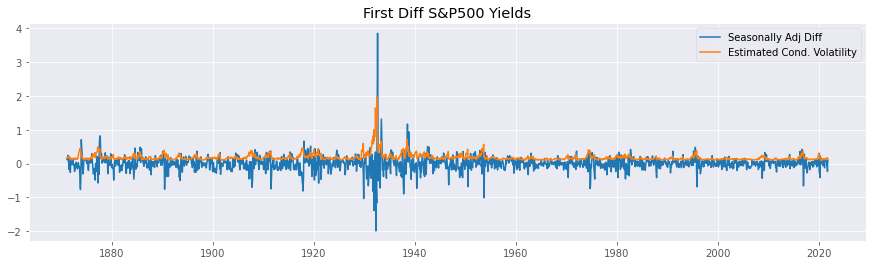

In [200]:
# S&P500 Yields
(p,q) = (best_params_dict['sp500']['p'], best_params_dict['sp500']['q'])
plt.plot(df_sp500['date'], df_sp500['diff_adj'], c='tab:blue')
plt.plot(df_sp500['date'], best_var_fit.conditional_volatility, c='tab:orange')
plt.legend(['Seasonally Adj Diff', 'Estimated Cond. Volatility'], loc='upper right')
plt.title("First Diff S&P500 Yields")

plt.show()